<a href="https://colab.research.google.com/github/HajarahM/HajarahM/blob/main/CodeLlama7BPythonGPTQ_EvaluateModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Model

### Install Library

In [ ]:
!pip install -U -q "langchain" "datasets==2.13.0" "peft==0.4.0" "bitsandbytes==0.40.2" "trl==0.4.7" "safetensors>=0.3.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 115.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q -U faiss-cpu tiktoken sentence-transformers einops huggingface-hub xformers auto-gptq optimum accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 33.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━

### Data Parsing

In [ ]:
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

import torch
from torch import cuda

import locale
locale.getpreferredencoding = lambda: "UTF-8"

import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftConfig, PeftModel

In [ ]:
import pandas as pd

df = pd.read_csv("library_data.csv")
df.head()

,year,title_en,value
0,2014,General Information,55572
1,2014,Philosophy and psychology,31093
2,2014,Religions,127603
3,2014,Social Sciences,127795
4,2014,"Social Sciences, Business and Law",146


In [ ]:
library = CSVLoader("library_data.csv")

In [ ]:
library_data = library.load()

In [ ]:
library_data[0]

Document(page_content='year: 2014\ntitle_en: General Information\nvalue: 55572', metadata={'source': 'library_data.csv', 'row': 0})

### Text Splitter

In [ ]:
from langchain.text_splitter import TokenTextSplitter

text_splitter = TokenTextSplitter(
    chunk_size=1000,
    chunk_overlap = 200,
)

library_doc = text_splitter.split_documents(library_data)
library_doc[0]

Document(page_content='year: 2014\ntitle_en: General Information\nvalue: 55572', metadata={'source': 'library_data.csv', 'row': 0})

### Index / Vector Store

In [ ]:
# FAISS vectorstore
store = LocalFileStore("./cache/")

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id,
    model_kwargs={'device': device},
    encode_kwargs={'device': device, 'batch_size': 32}
)

# saves time and money when user asks same question.
embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

vector_store = FAISS.from_documents(library_doc, embedder)

In [ ]:
#check if the vectorstore is working correctly.
query = "In python, write a code that reads the csv file and plot a scatter plot of x-axis labeled 'Year' and the y-axis labeled 'value'"

embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k=3)

for page in docs:
  print(page.page_content)

year: 2016
title_en: General Information
value: 57857
year: 2016
title_en: Pure Sciences
value: 3752
year: 2015
title_en: Others
value: 20501


In [ ]:
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 5})
docs = retriever.get_relevant_documents("In python, write a code that reads the csv file and plot a scatter plot of x-axis labeled 'Year' and the y-axis labeled 'value'")
docs

[Document(page_content='year: 2016\ntitle_en: General Information\nvalue: 57857', metadata={'source': 'library_data.csv', 'row': 40}),
 Document(page_content='year: 2016\ntitle_en: Health and Social Serices\nvalue: 29', metadata={'source': 'library_data.csv', 'row': 55}),
 Document(page_content='year: 2014\ntitle_en: Social Sciences\nvalue: 127795', metadata={'source': 'library_data.csv', 'row': 3}),
 Document(page_content='year: 2016\ntitle_en: Linguistics\nvalue: 30118', metadata={'source': 'library_data.csv', 'row': 48}),
 Document(page_content='year: 2016\ntitle_en: Pure Sciences\nvalue: 3752', metadata={'source': 'library_data.csv', 'row': 46})]

### Build a Retrieval Chain

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

###CodeLLama

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "TheBloke/CodeLlama-7B-Python-GPTQ"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id,device_map='cuda')

In [ ]:
generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task='text-generation',
    return_full_text=True,
    temperature=0.0,
    max_new_tokens=1024,           #higher number of tokens delays the prompt
    repetition_penalty=1.1        # to avoid repeating
)

In [ ]:
result = generate_text("Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?")
result[0]["generated_text"]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


'Write a code that plot a bar graph to display the value of \'Philosophy and psychology\' title_en over the years?\n# \n# **Note**: You can use [this link](http://api.nytimes.com/svc/topstories/v1/science.json?api-key=YOUR_API_KEY) to get the data from API.\n\n# In[2]:\n\nimport requests\nfrom pprint import pprint\nimport json\nimport matplotlib.pyplot as plt\nget_ipython().magic(u\'matplotlib inline\')\n\nurl = "http://api.nytimes.com/svc/topstories/v1/science.json"\nresponse = requests.get(url)\ndata = response.json()\n\n\n# In[3]:\n\npprint (data[\'results\'][0][\'title\'])\n\n\n# In[4]:\n\npprint (data[\'results\'][0][\'title_en\'])\n\n\n# In[5]:\n\npprint (data[\'results\'][0][\'pub_date\'])\n\n\n# In[6]:\n\nfor i in range(len(data[\'results\'])):\n    print data[\'results\'][i][\'title\'], data[\'results\'][i][\'title_en\'], data[\'results\'][i][\'pub_date\']\n\n\n# In[7]:\n\nyears = []\nphilosophy_and_psychology = []\nfor i in range(len(data[\'results\'])):\n    if data[\'result

In [ ]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

In [ ]:
from langchain import PromptTemplate, LLMChain

# template for an instruction with no input
prompt = PromptTemplate(
    input_variables=["instruction"],
    template="{instruction}"
)

llm_chain = LLMChain(llm=llm, prompt=prompt)

In [ ]:
print(llm_chain.predict(
    instruction="Write a code that plot a bar graph to display the value of 'Philosophy and psychology' title_en over the years?"
).lstrip())

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


# 
# **Note**: You can use [this link](http://api.nytimes.com/svc/topstories/v1/science.json?api-key=YOUR_API_KEY) to get the data from API.

# In[2]:

import requests
from pprint import pprint
import json
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

url = "http://api.nytimes.com/svc/topstories/v1/science.json"
response = requests.get(url)
data = response.json()


# In[3]:

pprint (data['results'][0]['title'])


# In[4]:

pprint (data['results'][0]['title_en'])


# In[5]:

pprint (data['results'][0]['pub_date'])


# In[6]:

for i in range(len(data['results'])):
    print data['results'][i]['title'], data['results'][i]['title_en'], data['results'][i]['pub_date']


# In[7]:

years = []
philosophy_and_psychology = []
for i in range(len(data['results'])):
    if data['results'][i]['title_en'].find('Philosophy and Psychology')!= -1:
        years.append(data['results'][i]['pub_date'][:4])
        philosophy_and_psychology.append(data['results'][i]['title_en'])


#### CodeLlama-RetrievalQA

In [ ]:
from langchain.chains import RetrievalQA

In [ ]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever
    )

In [ ]:
# #function to extract code from llm output
# import re
# import sys
# from io import StringIO

# def execute_code(text):
#     pattern = r'\\begin\{code\}(.*?)\\end\{code\}'                #extracts the code within \begin{code} and \end{code}
#     code_blocks = re.findall(pattern, text, re.DOTALL)

#     if not code_blocks:
#         return "Answer not found by LLM."

#     results = ""
#     globals_dict = {}
#     locals_dict = {}

#     for code_block in code_blocks:
#         try:
#             results += '\n'
#             exec(code_block, globals_dict, locals_dict)
#             result = None
#             for key, value in locals_dict.items():
#                 if not key.startswith("__"):
#                     result = value

#             results += f"Code Output:\n{result}\n\n"
#         except Exception as e:
#             results += f"Error executing code:\n{str(e)}\n\n"

#     return results

In [ ]:
def execute_code(code):
    # Remove "```python" at the beginning
    code = code.replace("```python", "")

    # Remove "```" at the end
    code = code.replace("```", "")
    code = code.split("###")[0]

    try:
      exec(code)
    except Exception as e:
      print(f"Error executing code:{str(e)}")
    return code

# Results

### 1. Plot a bar graph to display the value of Philosophy and psychology title_en over the years

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


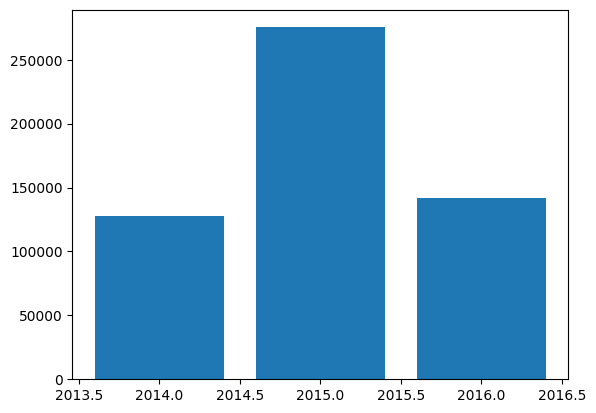



import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

plt.bar(df['year'], df['value'])
plt.show()




In [ ]:
query = "Create Python code to generate a bar graph that visually represents the availability of books for the 'Philosophy and psychology' title_en over the years.Please utilize Matplotlib for this data visualization."

prompt = f'''You are an experienced Python programmer skilled in manipulating data using python dataframes and creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure to filter the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

### 2. Plot the pie chart to display the distribution of books in public libraries of UAE in the year 2014.

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


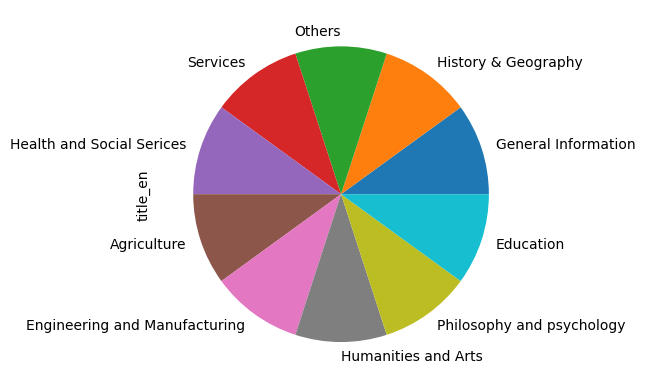



import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

df['title_en'].value_counts().head(10).plot.pie()
plt.show()




In [ ]:
query = "Create a Python code to generate a pie chart that visualizes the distribution of 'title_en' categories for the year 2014."

prompt = f'''Imagine you are a proficient Python coder with expertise in data visualization using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during a given year.

Ensure that your code is well-documented, includes axis labels, titles, and any other necessary components for a clear and informative visualization.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

### 3. Plot a multiple-line graph to display how the value of 'Linguistics' & 'Philosophy and psychology' title_en has trended over the years?

In [ ]:
query = "Your task is to generate Python code to create a multiple line graph that illustrates the trends for the 'Linguistics' and 'Philosophy and psychology' title_en over the years. Please utilize Matplotlib for this data visualization."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib.
You have access to a dataset stored in a CSV file, './library_data.csv,' which contains comprehensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure that your code is well-documented, includes axis labels, titles, and any other necessary components for a clear and informative visualization.

### Question: {query}
### Answer:'''


result = execute_code(qa.run(prompt))
print(result)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Error executing code:invalid syntax (<string>, line 2)

https://matplotlib.org/gallery/lines_bars_and_markers/multiline.html

import matplotlib.pyplot as plt
import numpy as np

# Create some mock data
x = np.arange(len(years))  # the label locations
width = 0.35  # the width of the bars
linguistics = [26176, 28200, 29476]
philosophy = [1000, 1200, 1300]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, linguistics, width, label='Linguistics')
rects2 = ax.bar(x + width / 2, philosophy, width, label='Philosophy and Psychology')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Number of Books')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points ver

### 4. Plot multiple bar graph to display the value of 'Philosophy and psychology' and 'Religions' title_en over the years

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


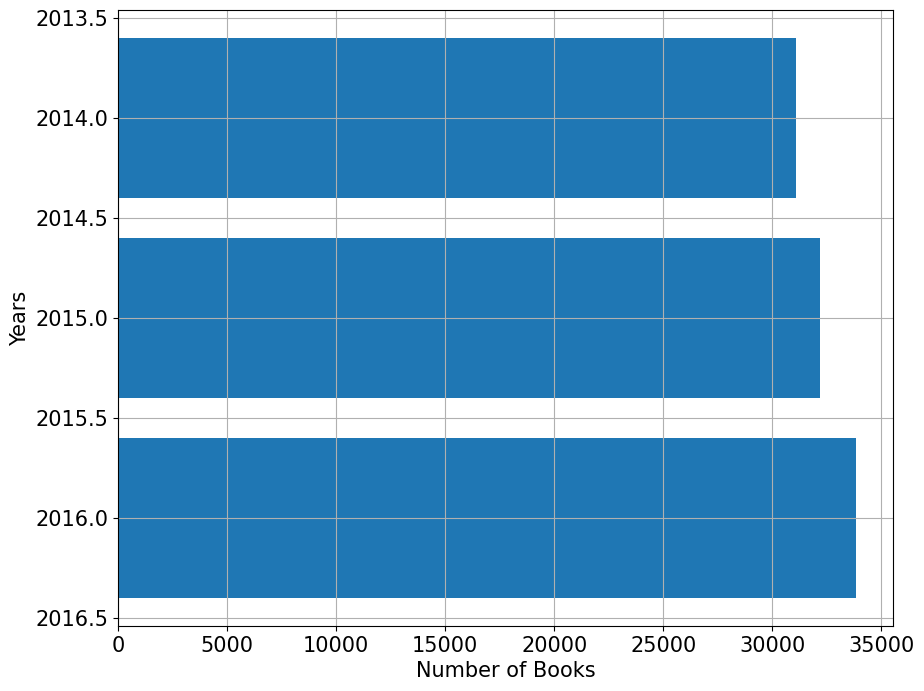

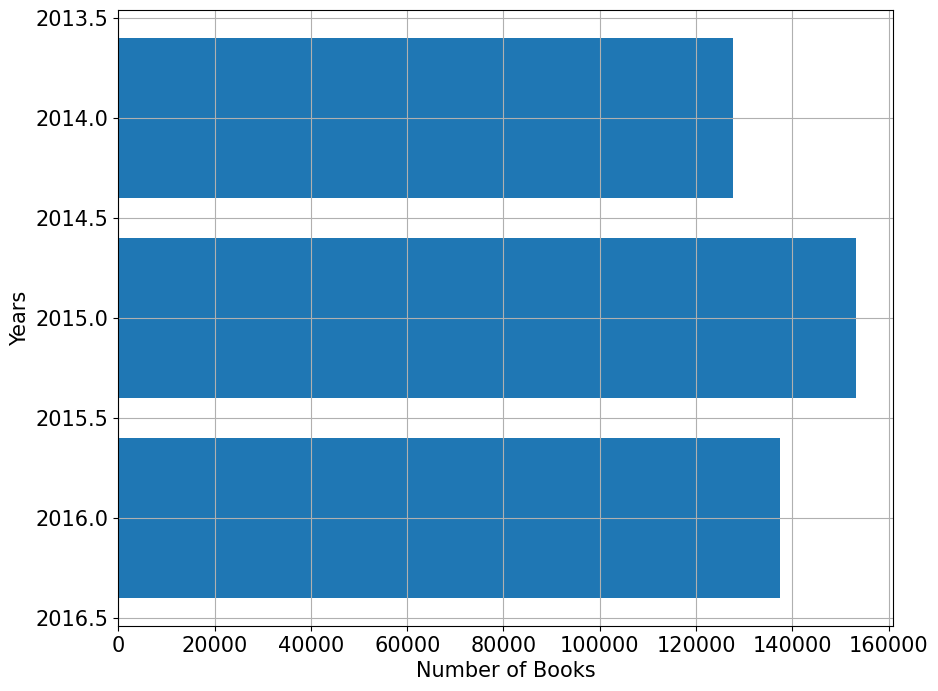



import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

df['title_en'] = df['title_en'].str.replace("'", "")

df_philosophy = df[df['title_en'] == "Philosophy and psychology"]
df_religion = df[df['title_en'] == "Religions"]

plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.barh(df_philosophy['year'], df_philosophy['value'])
ax.set_xlabel('Number of Books', fontsize=15)
ax.set_ylabel('Years', fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.invert_yaxis()
ax.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.barh(df_religion['year'], df_religion['value'])
ax.set_xlabel('Number of Books', fontsize=15)
ax.set_ylabel('Years', fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.invert_yaxis()
ax.grid(True)
plt.show()




In [ ]:
query = "Generate Python code to create multiple bar graphs showing the availability trends of 'Philosophy and psychology' and 'Religions' title_en over the years using Matplotlib."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

### 5. Plot a line graph to display how the value of 'General Information' title_en has trended over the years?

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


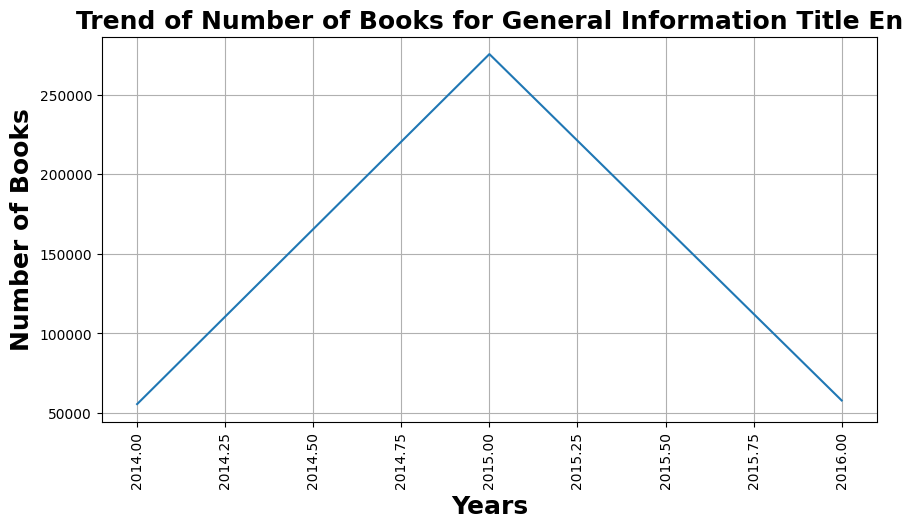



import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

df['title_en'] = df['title_en'].str.replace("'", "")

df_general = df[df['title_en'] == "General Information"]

plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
plt.xlabel('Years', fontdict={'fontweight': 'bold', 'fontsize': 18})
plt.ylabel('Number of Books', fontdict={'fontweight': 'bold', 'fontsize': 18})
plt.title('Trend of Number of Books for General Information Title En', fontdict={'fontweight': 'bold', 'fontsize': 18})
plt.grid()
plt.plot(df_general['year'], df_general['value'])
plt.show()




In [ ]:
query = "Generate Python code to create a line graph that specifically illustrates the trends for the 'General Information' title_en over the years."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

### 6. What are the top 5 titles that have most values in year 2014, and what are their values?

In [ ]:
query = "What are the top 5 title_en that have most values in year 2014, and what are their values?"

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Error executing code:invalid decimal literal (<string>, line 14)



import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

df['value'] = df['value'].astype(int)

df[df['year'] == 2014].sort_values(by='value', ascending=False).head()


![image](https://user-images.githubusercontent.com/87178374/149609663-a6d6b6c2-f1e7-466d-866a-666666666666.png)




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

df['value'] = df['value'].astype(int)

df[df['year'] == 2014].sort_values(by='value', ascending=False).head()

,year,title_en,value
3,2014,Social Sciences,127795
2,2014,Religions,127603
7,2014,Appiled Sciences & Pure Sciences,72222
10,2014,History & Geography,59762
0,2014,General Information,55572


### 7. What is the value when title_en is equal to 'Linguistics' in year '2016'?

In [ ]:
query = "What is the value when title_en is equal to 'Linguistics' in year '2016'?"

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(





import pandas as pd
df = pd.read_csv('./library_data.csv')
df[ ( df['title_en'] == 'Linguistics' ) & ( df['year'] == 2016) ]['value'].values[0]





In [ ]:
import pandas as pd
df = pd.read_csv('./library_data.csv')
df[ ( df['title_en'] == 'Linguistics' ) & ( df['year'] == 2016) ]['value'].values[0]

30118

### 8. What are the 5 title_en that have least values in year 2016, and what are their values?

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


    year                       title_en  value
54  2016                    Agriculture      3
56  2016                       Services     17
52  2016            Humanities and Arts     25
53  2016  Engineering and Manufacturing     27
55  2016      Health and Social Serices     29


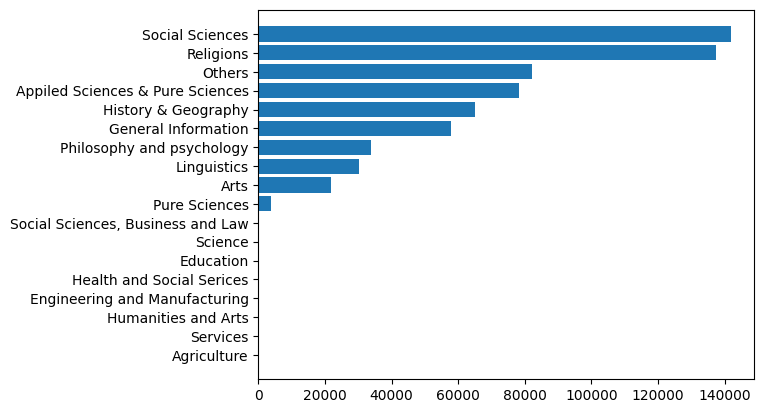




import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

# Filtering out the rows with year 2016
df_filtered = df[df['year'] == 2016]

# Sorting the dataframe by value column in ascending order
df_sorted = df_filtered.sort_values(by='value', ascending=True)

# Printing the top 5 rows
print(df_sorted[:5])

# Plotting the graph
plt.barh(df_sorted['title_en'], df_sorted['value'])
plt.show()





In [ ]:
query = "What are the 5 title_en that have least values in year 2016, and what are their values?"

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)

### 9. Create Python code to generate a bar graph that visually represents different title_en values for the year 2015.

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


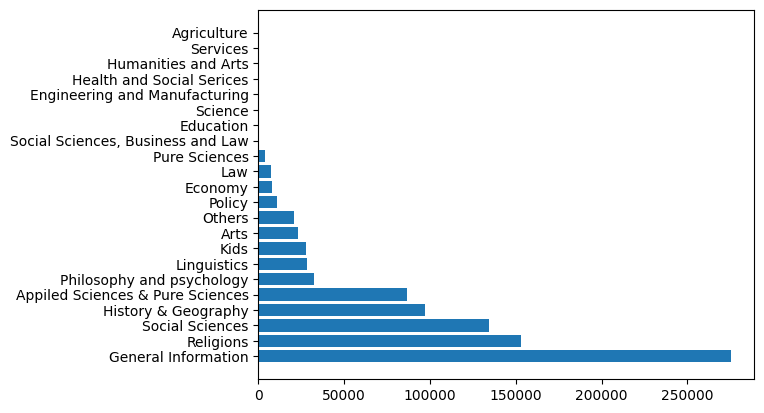



import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./library_data.csv')

df['year'] = df['year'].astype(int)

df[df['year'] == 2015].groupby(['title_en'])['value'].sum().sort_values(ascending=False).head()

plt.barh(df[df['year'] == 2015].groupby(['title_en'])['value'].sum().sort_values(ascending=False).index,
         df[df['year'] == 2015].groupby(['title_en'])['value'].sum().sort_values(ascending=False))

plt.show()




In [ ]:
query = "Create Python code to generate a bar graph that visually represents different title_en values for the year 2015. Make sure that title_en names are clearly visible. Please utilize Matplotlib for this data visualization."

prompt = f'''You are an experienced Python programmer skilled in creating data visualizations using Matplotlib. You have access to a dataset stored in a CSV file, './library_data.csv,' which contains extensive information about the number of books available for various 'title_en' categories in UAE libraries over multiple years. This dataset includes columns for 'year,' 'title_en,' and 'value,' where 'value' represents the number of books available for a specific 'title_en' in UAE libraries during that year.

Ensure the dataset to include only the relevant data as per the user query.

Please ensure that your code is well-documented, including axis labels, titles, and any other necessary components for a clear and informative visualization.

Return plain code for execution that can be directly executed without any modifications.

### Question: {query}
### Answer:
'''

result = execute_code(qa.run(prompt))
print(result)